## Sardinia + Sherpa + Gosling + HGDP 

In this script, we consider the signature counts data from the Sardinian samples, the Gosling samples, the Sherpa samples and the HGDP samples.  Here we illustrate 

- The clustering of the samples from HGDP (modern samples), the Sherpa (ancient samples), Gosling samples (only ancients) and the Sardinian samples (ancient samples)
- Visualize the clustering results for the three populations

In [2]:
options(warn=-1)
library(aRchaic)
library(CountClust)
library(maptpx)
library(grid)
library(gridBase)

Loading required package: ggplot2


In [3]:
## Pooling data from the different cources 

gossling_data <- get(load("../processed_data/annagosling2016-counts-table.rda"))
system.time(gossling_data_clubbed <- club_signature_counts(gossling_data))
gossling_data_clubbed <- gossling_data_clubbed[-28,];

names <- rownames(gossling_data_clubbed);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

labs <- character();
labs <- rep("ancient", dim(gossling_data_clubbed)[1])
labs[control_indices] <- "controls"

indices <- which(labs == "ancient")

ancient_names = names[indices]
pop_names_1 <- as.factor(substring(ancient_names, 8, 8))
levels(pop_names_1)

levels(pop_names_1) = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong")
labs[indices] <- as.character(pop_names_1)

gossling_ancients <- gossling_data_clubbed[indices, ]
gossling_filtered_counts <- filter_signatures_by_location(gossling_ancients, max_pos=20, flanking_bases = 2)


sherpa_data <- get(load("../processed_data/sherpa2017.rda"))
sherpa_data <- club_signature_counts(sherpa_data)
sherpa_filtered_counts <- filter_signatures_by_location(sherpa_data, max_pos=20, flanking_bases = 2)

sardinia_data <- get(load("../processed_data/sardinia2017.rda"))
sardinia_data <- club_signature_counts(sardinia_data)
sardinia_filtered_counts <- filter_signatures_by_location(sardinia_data, max_pos=20, flanking_bases = 2)

hgdp_data <- get(load("../processed_data/HGDPmoderns-counts-table.rda"))
hgdp_data <- club_signature_counts(hgdp_data)
hgdp_filtered_counts <- filter_signatures_by_location(hgdp_data, max_pos=20, flanking_bases = 2)


pooled_names <- intersect(colnames(sherpa_filtered_counts),
                          intersect(colnames(sardinia_filtered_counts),
                                    intersect( colnames(hgdp_filtered_counts), colnames(gossling_filtered_counts))))


filtered_gossling <- gossling_filtered_counts[, match(pooled_names, colnames(gossling_filtered_counts))]
filtered_sherpa <- sherpa_filtered_counts[, match(pooled_names, colnames(sherpa_filtered_counts))]
filtered_sardinia <- sardinia_filtered_counts[, match(pooled_names, colnames(sardinia_filtered_counts))]
filtered_hgdp <- hgdp_filtered_counts[, match(pooled_names, colnames(hgdp_filtered_counts))]

pooled_data <- rbind(filtered_gossling, filtered_sherpa, filtered_sardinia, filtered_hgdp)

   user  system elapsed 
 20.589   0.676  23.737 

[1] "C" "K" "M" "R" "S"

In [4]:
## Defining the signatures as factors

signature_set <- colnames(pooled_data)
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]][1:8])))
new_sig_split <- matrix(0, dim(sig_split)[1], 5);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]

#indices_notCtoA <-  which(new_sig_split[,3] != "C->T")
#pooled_data <- pooled_data[, indices_notCtoA]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

pos <- t(sapply(1:length(signature_set), function(x)
{
  y = strsplit(signature_set[x], "")[[1]]
  return(paste(y[10:length(y)], collapse=""))
}))



mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
  temp <- as.factor(new_sig_split[,k])
  mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

pos <- as.numeric(pos)
pos <- pos - min(pos)
pos <- factor(pos, levels = 0:20)

signatures <- mat;
signature_pos <- cbind.data.frame(signatures, pos)

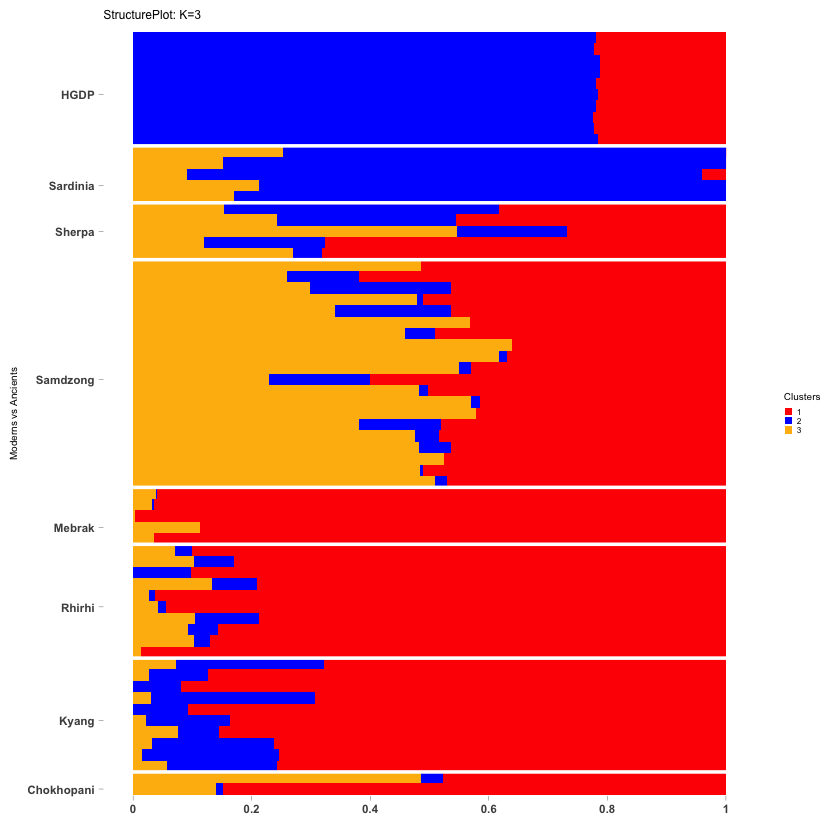

In [5]:
## Grade of membership model for K=3

#out <- maptpx::topics(pooled_data, K=4, tol=100, model="independent", signatures = signature_pos)
#save(out, file="../processed_data/maptpx-runs/sards-gosling-sherpa-hgdp-maptpx-independent-K-4.rda")
out <- get(load("../processed_data/maptpx-runs/sards-gosling-sherpa-hgdp-maptpx-independent-K-3.rda"))

labs1 <- c(labs[indices],
          rep("Sherpa", dim(filtered_sherpa)[1]),
          rep("Sardinia", dim(filtered_sardinia)[1]),
          rep("HGDP", dim(filtered_hgdp)[1]))

omega <- out$omega

cols1 <- c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
           "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
           "brown4","darkorchid","magenta","yellow", "azure1","azure4")

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs1, levels = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong",
                                          "Sherpa", "Sardinia", "HGDP"))
)

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = cols1,
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],""),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))


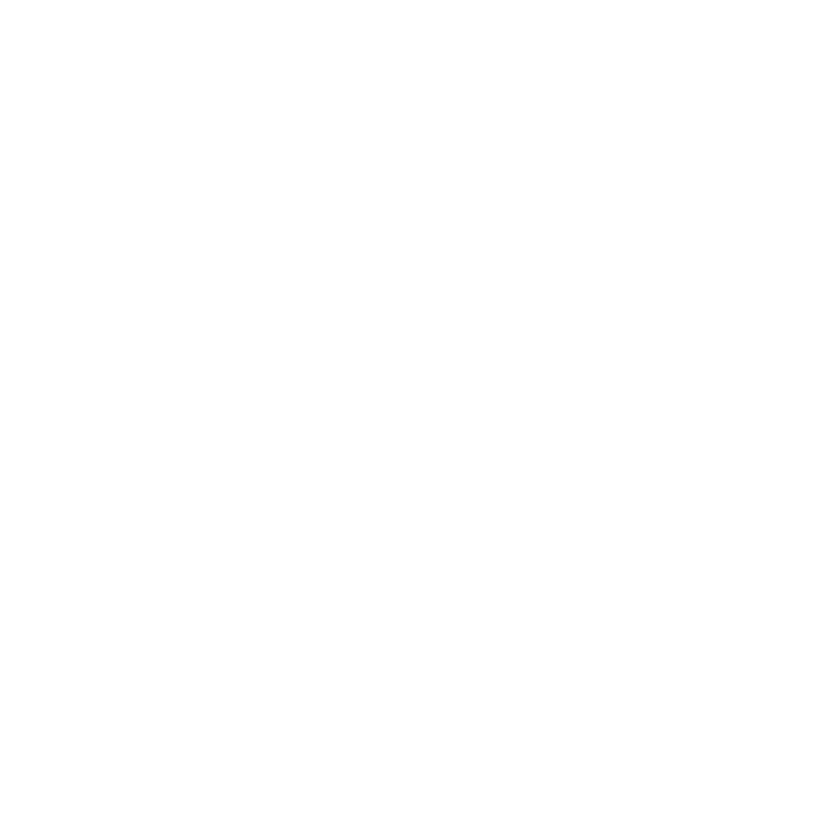

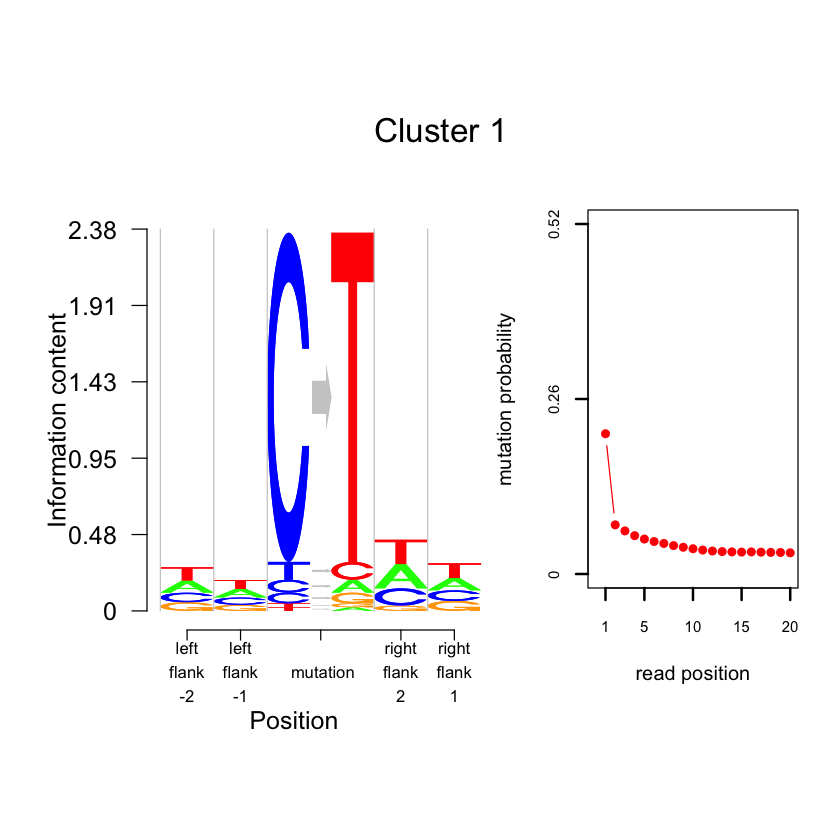

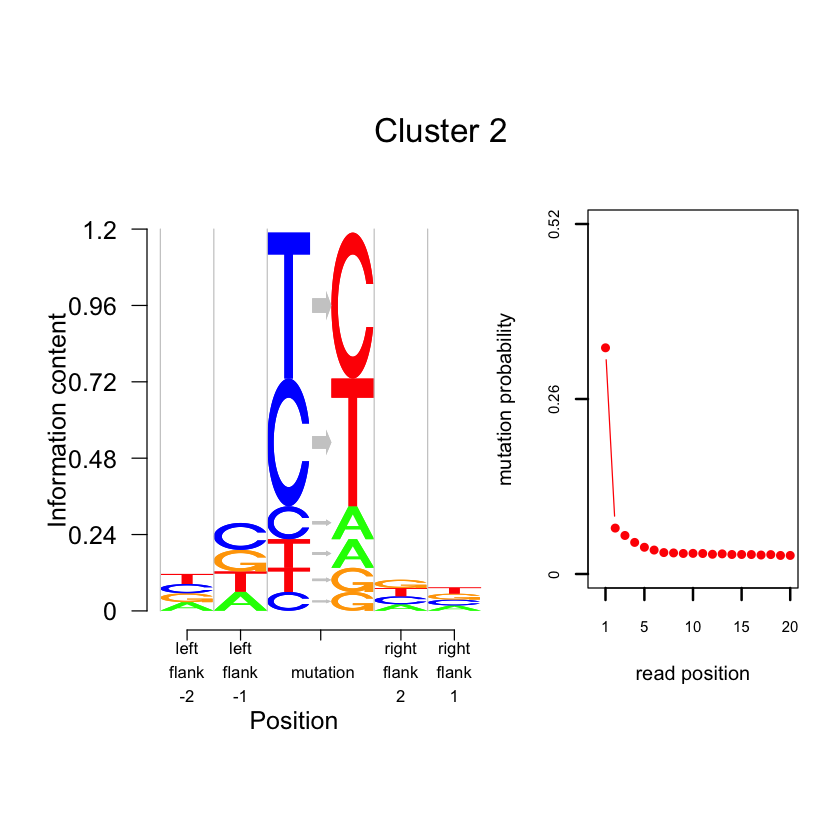

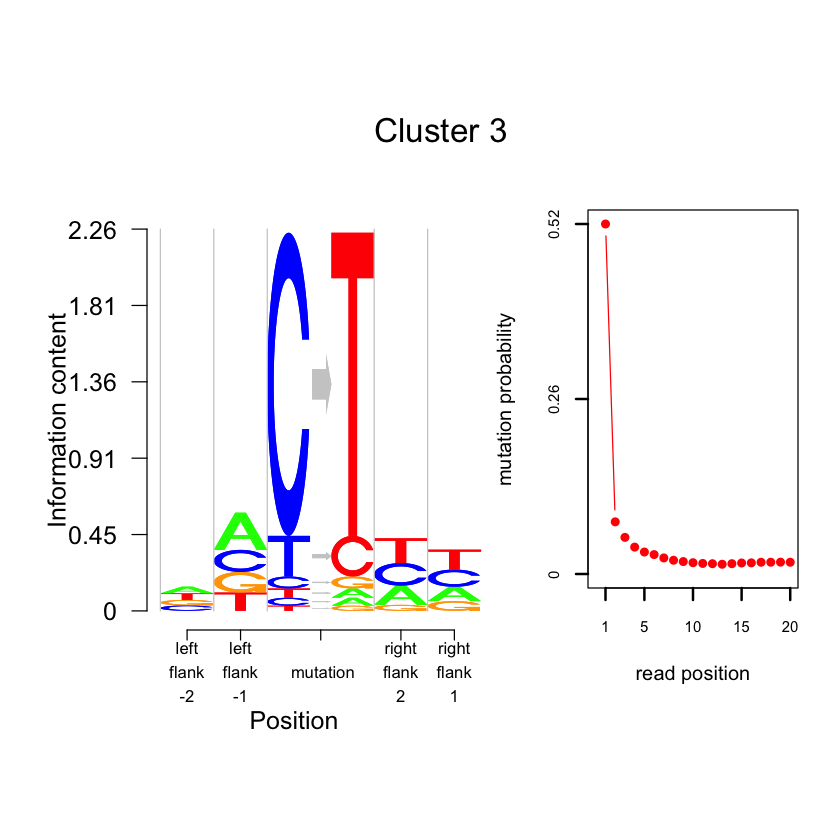

In [7]:
plot.new()
damageLogo_pos(out$theta, renyi_alpha = 100)

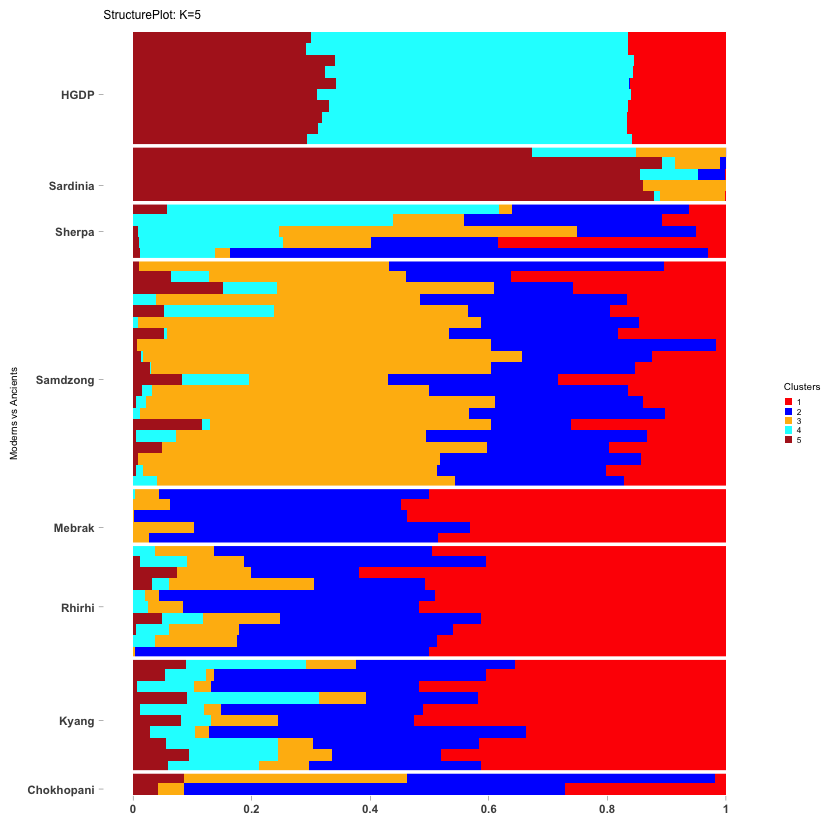

In [8]:
## Grade of membership model for K=5

out <- get(load("../processed_data/maptpx-runs/sards-gosling-sherpa-hgdp-maptpx-independent-K-5.rda"))

labs1 <- c(labs[indices],
          rep("Sherpa", dim(filtered_sherpa)[1]),
          rep("Sardinia", dim(filtered_sardinia)[1]),
          rep("HGDP", dim(filtered_hgdp)[1]))

omega <- out$omega

cols1 <- c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
           "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
           "brown4","darkorchid","magenta","yellow", "azure1","azure4")

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs1, levels = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong",
                                          "Sherpa", "Sardinia", "HGDP"))
)

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = cols1,
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],""),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))


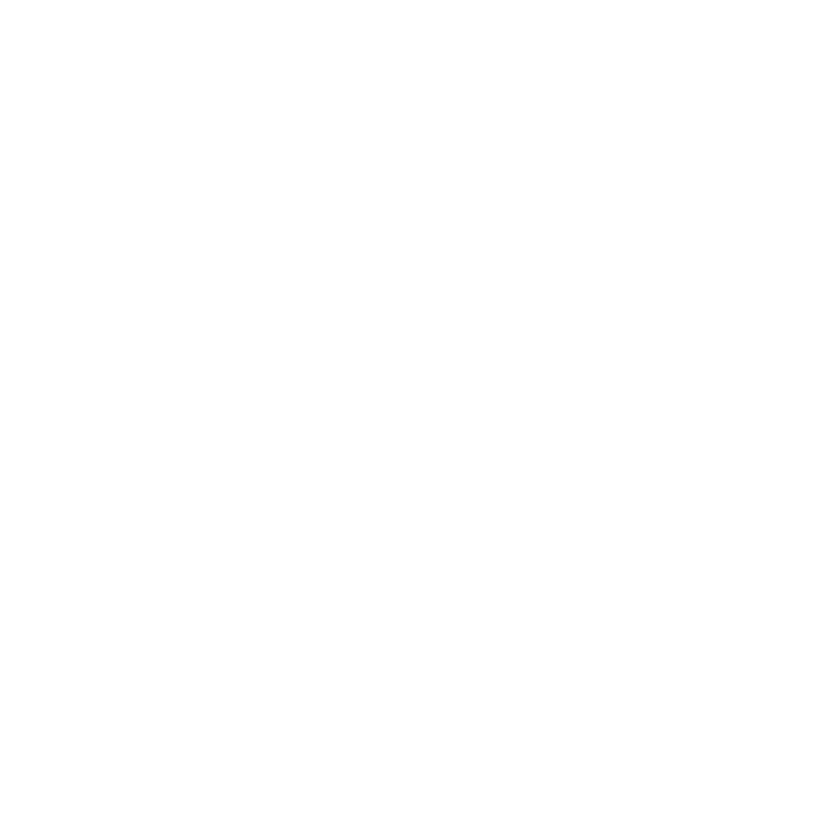

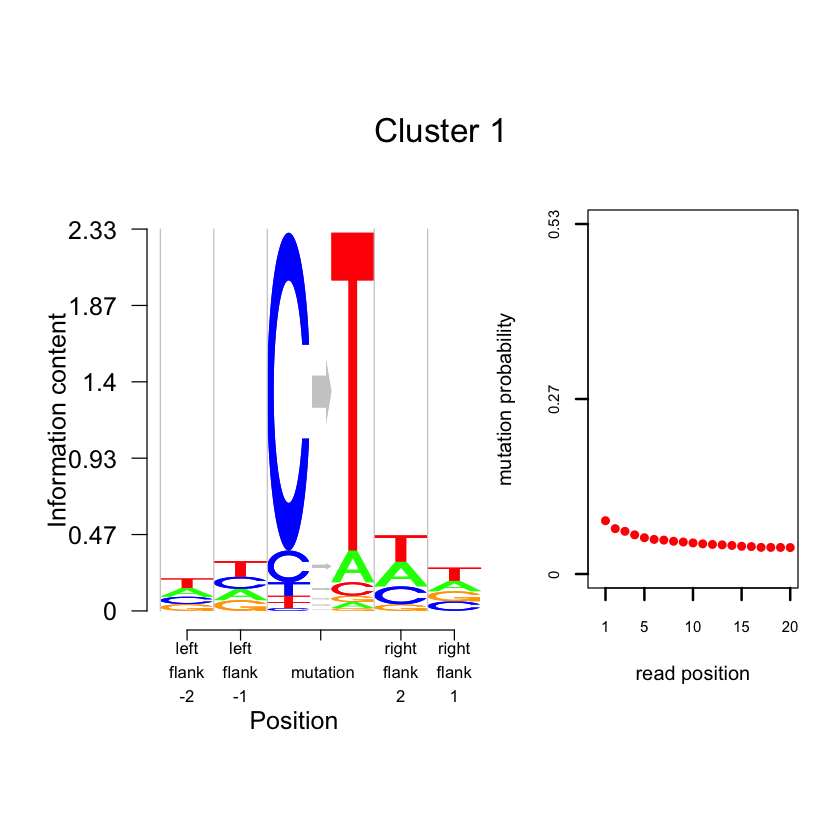

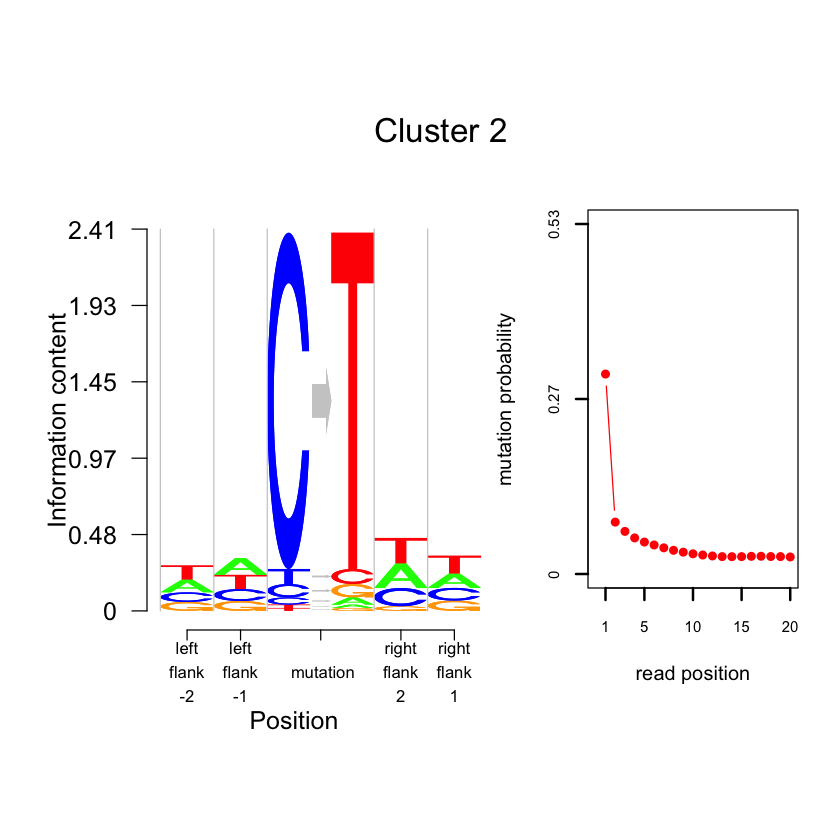

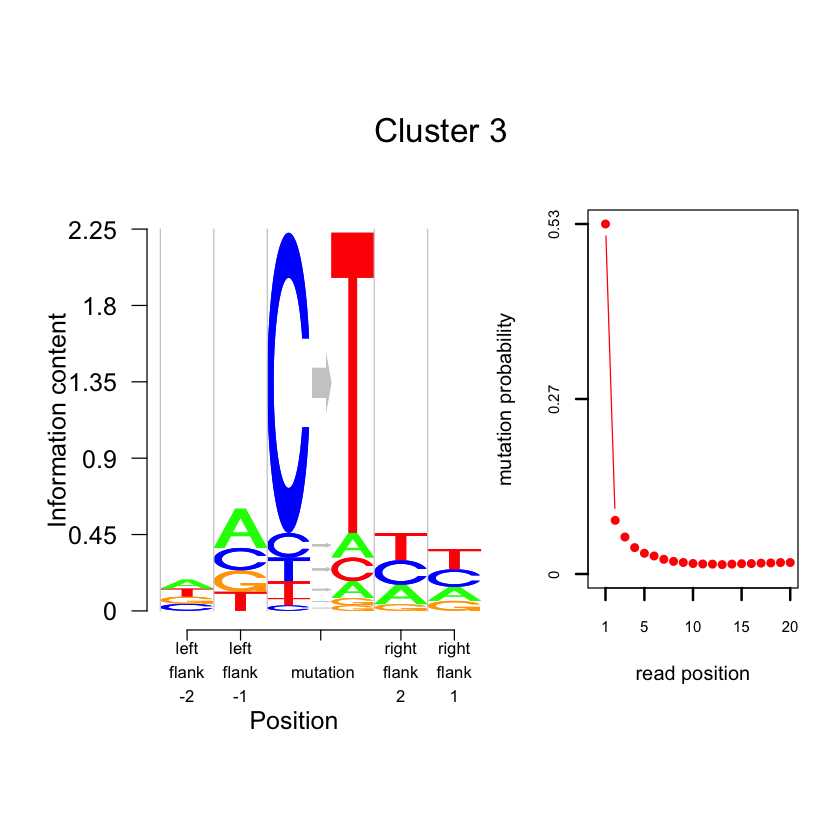

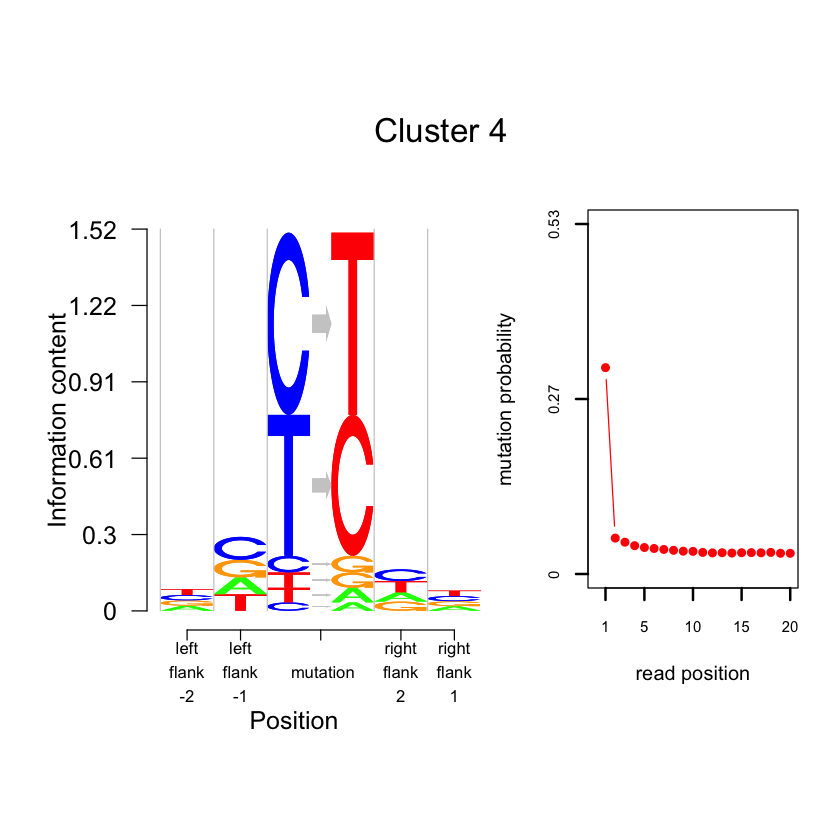

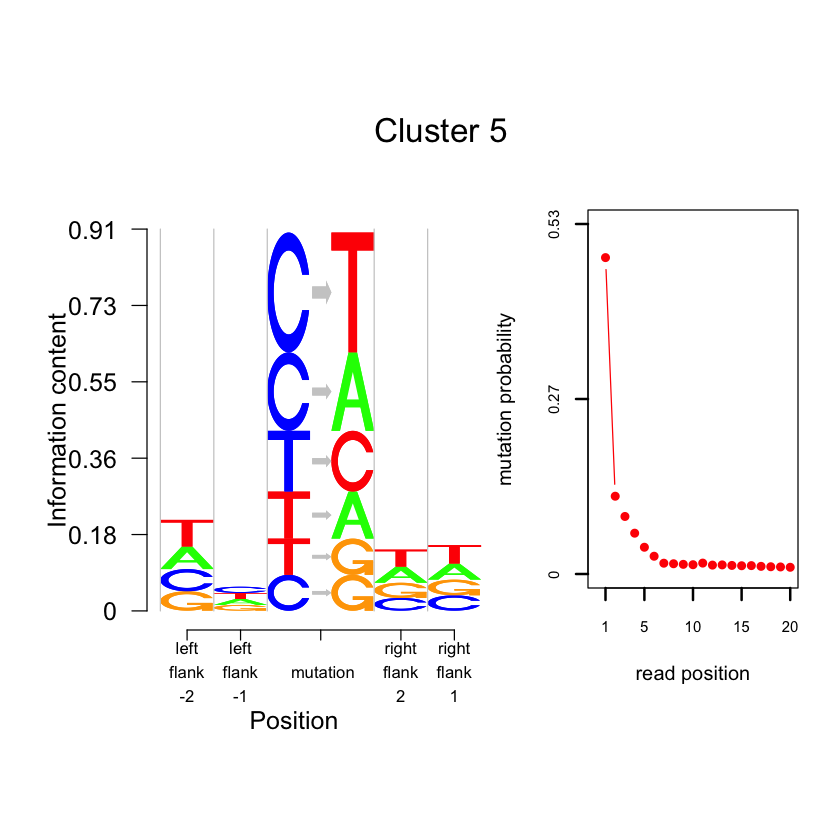

In [9]:
plot.new()
damageLogo_pos(out$theta, renyi_alpha = 100)

[1]  2.091109e-02  1.910882e-02  1.737509e-02  1.571295e-02  1.412542e-02
 [6]  1.261551e-02  1.118627e-02  9.840714e-03  8.581874e-03  7.412777e-03
[11]  6.338853e-03  5.358881e-03  4.465905e-03  3.652974e-03  2.913132e-03
[16]  2.239428e-03  1.624907e-03  1.062615e-03  5.455991e-04  1.506958e-04
[21] -6.289634e-05 -1.285875e-04 -7.978777e-05  5.009282e-05  2.276442e-04
[26]  4.194562e-04  5.921189e-04  7.122220e-04  7.463557e-04  7.319943e-04
[31]  7.272749e-04  7.297806e-04  7.370948e-04  7.468006e-04  7.564815e-04
[36]  7.637207e-04  7.661015e-04  7.612071e-04  7.517089e-04  7.419343e-04
[41]  7.319510e-04  7.218265e-04  7.116284e-04  7.014241e-04  6.912814e-04
[46]  6.812677e-04  6.714506e-04  6.618978e-04  6.469216e-04  6.231982e-04
[51]  5.943406e-04  5.639619e-04  5.356751e-04  5.130932e-04  4.998291e-04
[56]  4.994960e-04  5.157068e-04  5.429683e-04  5.737329e-04  6.085324e-04
[61]  6.478985e-04  6.923628e-04  7.424571e-04  7.987131e-04  8.616626e-04
[66]  9.318371e-04  1.009768e-03  1.095475e-03  1.188465e-03  1.288504e-03
[71]  1.395359e-03  1.508797e-03  1.628582e-03  1.754482e-03  1.886262e-03
[76]  2.023690e-03

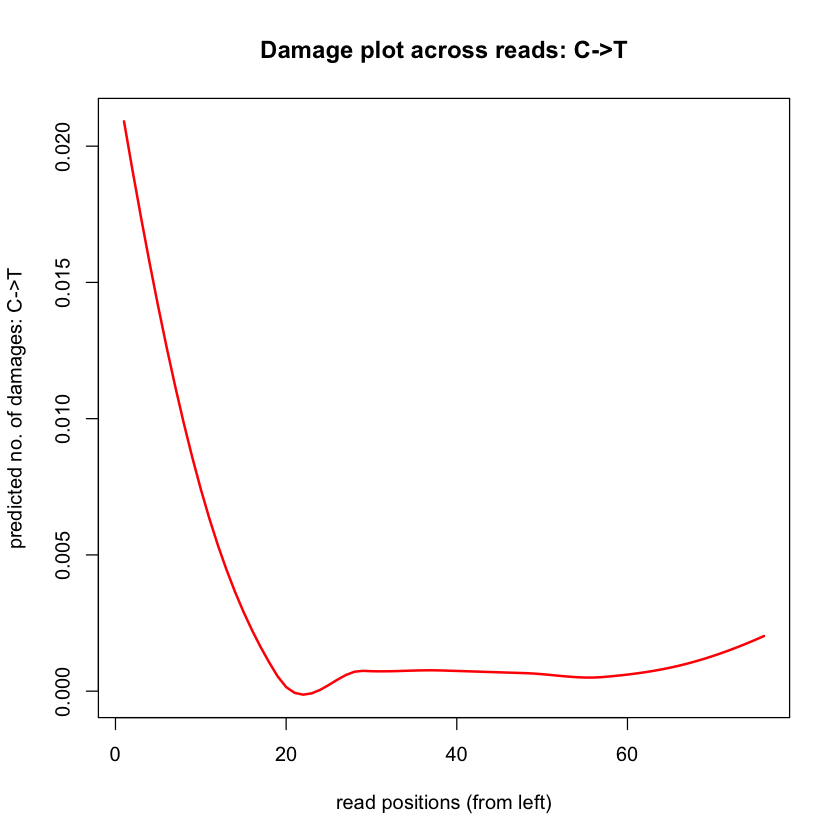

[1]  2.608989e-02  2.382380e-02  2.164392e-02  1.955415e-02  1.755835e-02
 [6]  1.566042e-02  1.386424e-02  1.217369e-02  1.059265e-02  9.125008e-03
[11]  7.777731e-03  6.549266e-03  5.430721e-03  4.413202e-03  3.487815e-03
[16]  2.645667e-03  1.877863e-03  1.175510e-03  5.297147e-04  3.821193e-05
[21] -2.237173e-04 -2.986484e-04 -2.291567e-04 -5.781746e-05  1.727939e-04
[26]  4.201020e-04  6.415314e-04  7.945070e-04  8.364532e-04  8.140529e-04
[31]  8.008199e-04  7.944258e-04  7.925418e-04  7.928393e-04  7.929897e-04
[36]  7.906645e-04  7.835349e-04  7.692724e-04  7.500863e-04  7.299167e-04
[41]  7.090312e-04  6.876974e-04  6.661828e-04  6.447551e-04  6.236818e-04
[46]  6.032305e-04  5.836688e-04  5.652642e-04  5.427062e-04  5.126498e-04
[51]  4.783117e-04  4.429084e-04  4.096562e-04  3.817718e-04  3.624716e-04
[56]  3.549722e-04  3.624900e-04  3.801294e-04  4.011661e-04  4.260738e-04
[61]  4.553260e-04  4.893966e-04  5.287590e-04  5.738871e-04  6.252543e-04
[66]  6.833344e-04  7.486010e-04  8.210681e-04  9.002954e-04  9.860754e-04
[71]  1.078200e-03  1.176462e-03  1.280654e-03  1.390568e-03  1.505996e-03
[76]  1.626730e-03

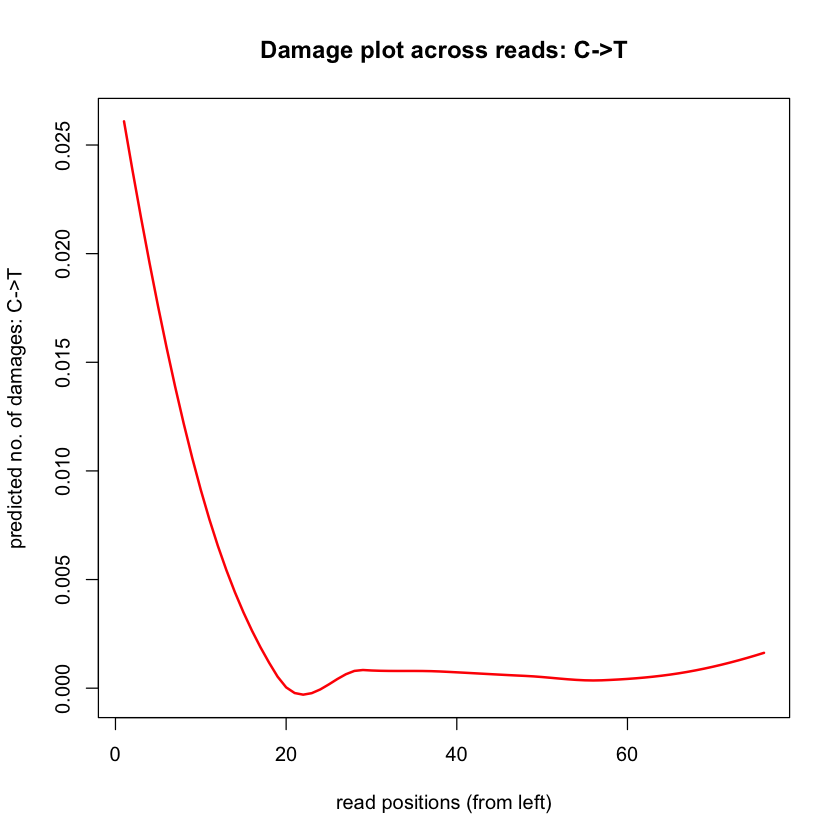

[1] 0.0174933134 0.0161067466 0.0147715358 0.0134896696 0.0122631366
 [6] 0.0110939253 0.0099840242 0.0089354219 0.0079501069 0.0070300678
[11] 0.0061788760 0.0053956327 0.0046756211 0.0040141241 0.0034064250
[16] 0.0028478067 0.0023335525 0.0018589453 0.0014192683 0.0010697999
[21] 0.0008532248 0.0007459350 0.0007243229 0.0007647807 0.0008437005
[26] 0.0009374746 0.0010224953 0.0010751547 0.0010718451 0.0010418677
[31] 0.0010275661 0.0010248959 0.0010298128 0.0010382727 0.0010462312
[36] 0.0010496439 0.0010444667 0.0010266552 0.0009996359 0.0009699329
[41] 0.0009381484 0.0009048846 0.0008707439 0.0008363283 0.0008022402
[46] 0.0007690818 0.0007374553 0.0007079629 0.0006734394 0.0006291116
[51] 0.0005791699 0.0005278051 0.0004792075 0.0004375678 0.0004070763
[56] 0.0003919238 0.0003963006 0.0004138076 0.0004356598 0.0004624686
[61] 0.0004948458 0.0005334029 0.0005787515 0.0006315033 0.0006922699
[66] 0.0007616628 0.0008402937 0.0009281740 0.0010247301 0.0011296964
[71] 0.0012428073 0.0013637973 0.0014924008 0.0016283520 0.0017713855
[76] 0.0019212356

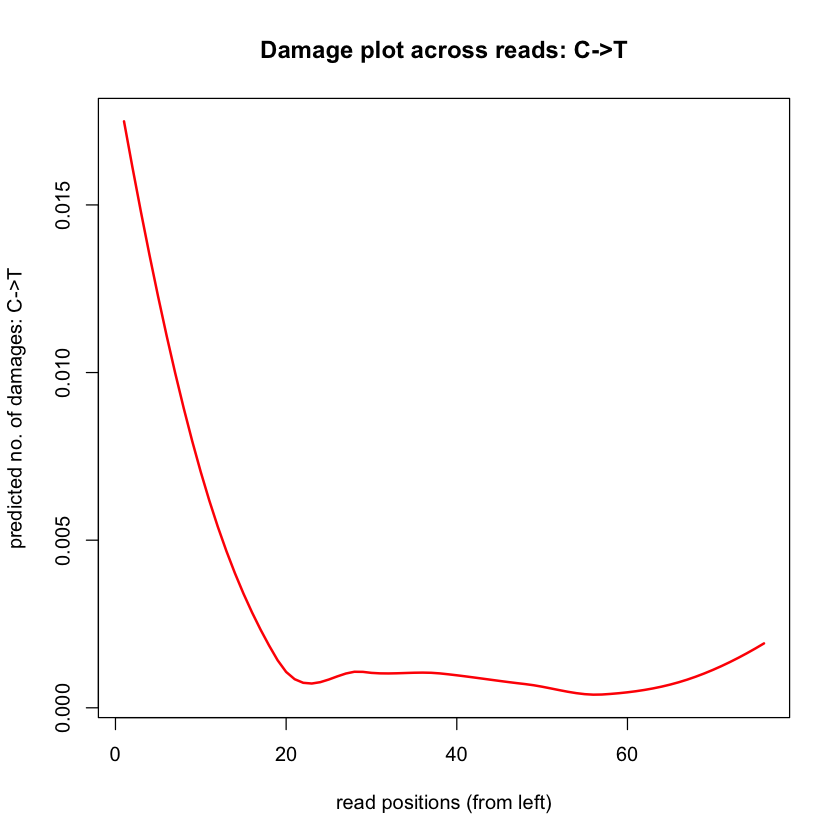

[1] 1.987790e-02 1.819252e-02 1.657093e-02 1.501590e-02 1.353019e-02
 [6] 1.211655e-02 1.077776e-02 9.516566e-03 8.335735e-03 7.238029e-03
[11] 6.228395e-03 5.305687e-03 4.463522e-03 3.695518e-03 2.995293e-03
[16] 2.356465e-03 1.772652e-03 1.237472e-03 7.445425e-04 3.652163e-04
[21] 1.544976e-04 8.148089e-05 1.152608e-04 2.249320e-04 3.795890e-04
[26] 5.483263e-04 7.002386e-04 8.044204e-04 8.299664e-04 8.120786e-04
[31] 8.047411e-04 8.052208e-04 8.107851e-04 8.187011e-04 8.262358e-04
[36] 8.306566e-04 8.292305e-04 8.192246e-04 8.030889e-04 7.853236e-04
[41] 7.662722e-04 7.462779e-04 7.256841e-04 7.048339e-04 6.840708e-04
[46] 6.637379e-04 6.441786e-04 6.257362e-04 6.016840e-04 5.677925e-04
[51] 5.281507e-04 4.868474e-04 4.479717e-04 4.156125e-04 3.938588e-04
[56] 3.867994e-04 3.985234e-04 4.228115e-04 4.511154e-04 4.840306e-04
[61] 5.221524e-04 5.660764e-04 6.163978e-04 6.737122e-04 7.386150e-04
[66] 8.117016e-04 8.935674e-04 9.842398e-04 1.083174e-03 1.190107e-03
[71] 1.304778e-03 1.426923e-03 1.556280e-03 1.692586e-03 1.835579e-03
[76] 1.984996e-03

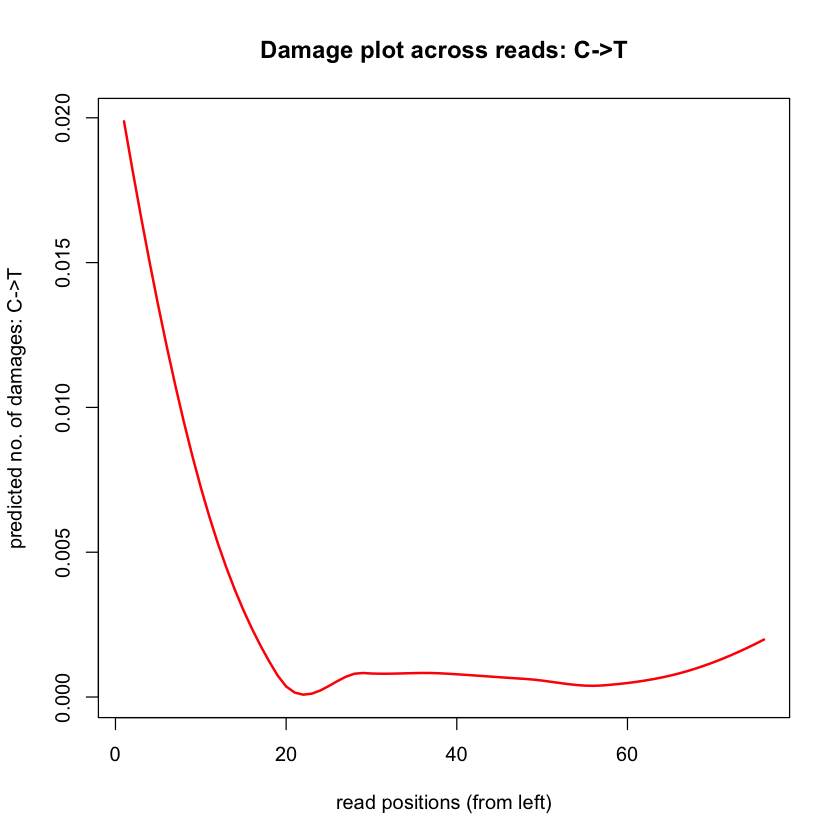

[1]  3.433028e-02  3.137226e-02  2.852641e-02  2.579788e-02  2.319180e-02
 [6]  2.071332e-02  1.836760e-02  1.615976e-02  1.409495e-02  1.217833e-02
[11]  1.041917e-02  8.815518e-03  7.355642e-03  6.027807e-03  4.820279e-03
[16]  3.721324e-03  2.719208e-03  1.802198e-03  9.585594e-04  3.145637e-04
[21] -3.244212e-05 -1.375765e-04 -5.595791e-05  1.572952e-04  4.470643e-04
[26]  7.582309e-04  1.035677e-03  1.224283e-03  1.268931e-03  1.232573e-03
[31]  1.212113e-03  1.203367e-03  1.202152e-03  1.204283e-03  1.205574e-03
[36]  1.201843e-03  1.188904e-03  1.162572e-03  1.126606e-03  1.087930e-03
[41]  1.047112e-03  1.004719e-03  9.613200e-04  9.174817e-04  8.737721e-04
[46]  8.307587e-04  7.890094e-04  7.490917e-04  7.053974e-04  6.540722e-04
[51]  5.983155e-04  5.413262e-04  4.863037e-04  4.364469e-04  3.949552e-04
[56]  3.650276e-04  3.498633e-04  3.444761e-04  3.420774e-04  3.431627e-04
[61]  3.482272e-04  3.577666e-04  3.722762e-04  3.922514e-04  4.181876e-04
[66]  4.505803e-04  4.899249e-04  5.362145e-04  5.889709e-04  6.479828e-04
[71]  7.130391e-04  7.839285e-04  8.604397e-04  9.423615e-04  1.029483e-03
[76]  1.121592e-03

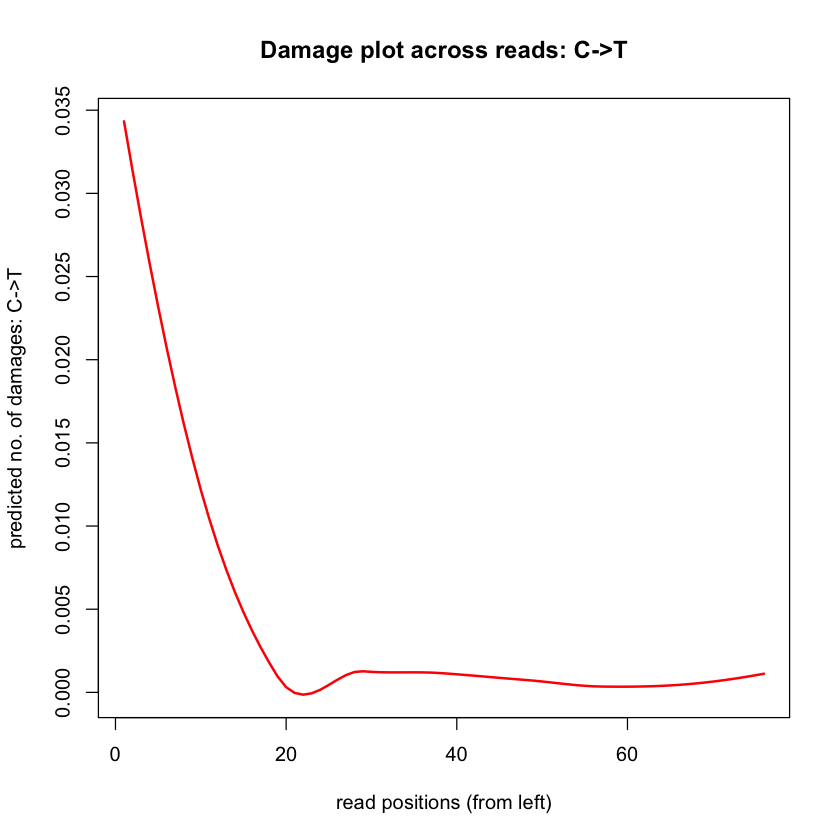

In [11]:
pattern_plot("../data/Sardinia2017/ISB001.A0201_S0_L008_R1_001.fastq.fq.qF.sorted.cleaned_rmdup.q30.csv", pattern="C->T", plot_type = "left", use_prop = TRUE)
pattern_plot("../data/Sardinia2017/LON001.A0201_S0_L008_R1_001.fastq.fq.qF.sorted.cleaned_rmdup.q30.csv", pattern="C->T", plot_type = "left", use_prop = TRUE)
pattern_plot("../data/Sardinia2017/SUA001.A0201_S0_L008_R1_001.fastq.fq.qF.sorted.cleaned_rmdup.q30.csv", pattern="C->T", plot_type = "left", use_prop = TRUE)
pattern_plot("../data/Sardinia2017/SUA002.A0201_S0_L008_R1_001.fastq.fq.qF.sorted.cleaned_rmdup.q30.csv", pattern="C->T", plot_type = "left", use_prop = TRUE)
pattern_plot("../data/Sardinia2017/SUA003.A0201_S0_L008_R1_001.fastq.fq.qF.sorted.cleaned_rmdup.q30.csv", pattern="C->T", plot_type = "left", use_prop = TRUE)


In [10]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridBase_0.4-7   maptpx_1.9-3     CountClust_0.1.2 ggplot2_2.2.1   
[5] aRchaic_0.99.0  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8         plyr_1.8.4          tools_3.3.1        
 [4] boot_1.3-18         digest_0.6.11       uuid_0.1-2         
 [7] nlme_3.1-128        jsonlite_1.2        evaluate_0.10      
[10] tibble_1.2          gtable_0.2.0        lattice_0.20-34    
[13] mgcv_1.8-16         Matrix_1.2-7.1      IRdisplay_0.4.4    
[16] parallel_3.3.1      IRkernel_0.7.1      gridExtra_2.2.1    
[19] cluster_2.0.5       repr_0.10           stringr_1.1.0      
[22] gtools_3.5.0        stats4_3.3.1        nnet_7.3-12        
[25] cowplot_0.7.0  